In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from rl_algorithms import *
from plots import *
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2.1

## Question 1

In [2]:
n_episodes = 20000
averaging_steps = 250
turns = np.array(['X','O'])

q_player = QPlayer(0.05, 0.99, 0.2)
env = TictactoeEnv()

rewards = []
average_reward = 0.

other_player = OptimalPlayer(epsilon=0.5, player=turns[1])
x = []

for episode in range(n_episodes):
        if episode % 5000 == 0:
            print('Current episode: %d' % episode)

        # Update players
        other_player.set_player(turns[1])
        
        # Play game
        reward = play_game(env, q_player, other_player, turns, testing=False)
        average_reward += reward

        if episode % averaging_steps == averaging_steps - 1:
            average_reward /= averaging_steps
            rewards.append(average_reward)
            average_reward = 0.
            x.append(episode)

        # Change first player
        turns = turns[::-1]

Current episode: 0
Current episode: 5000
Current episode: 10000
Current episode: 15000


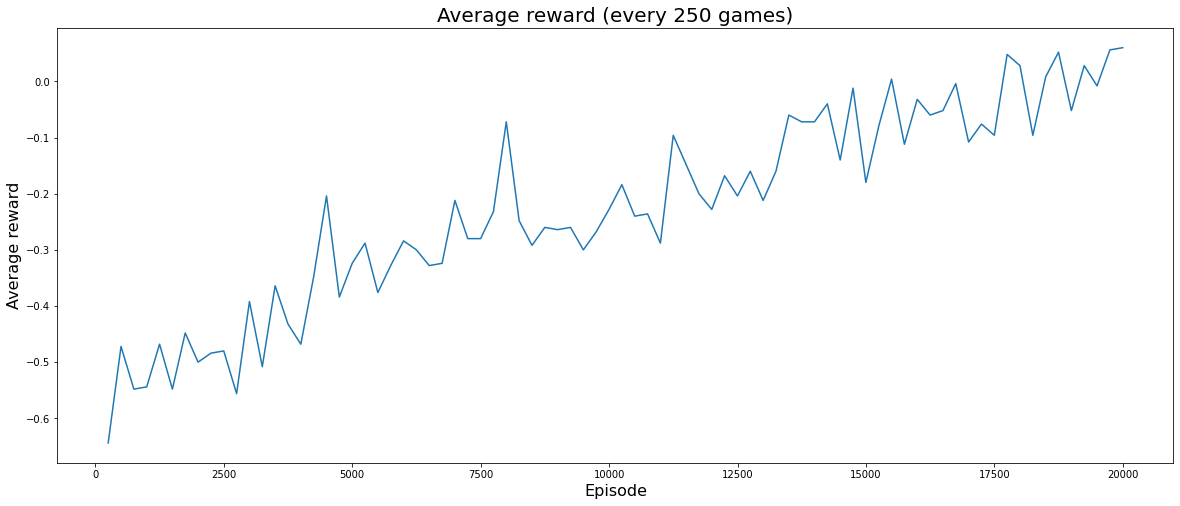

In [11]:
plot_average(x, rewards)

In this case we set $\epsilon_{opt}=0.5$. We can observe that the avarage reward computed every 250 games increases over time, going from a value of $-0.5$ to a value around $-0.2$

# 2.1.1

In [7]:
def run_episodes(n_episodes, q_player, other_player, update_epsilon=False, update_other_epsilon=False, set_player=True):
    rewards = []
    M_opts = []
    M_rands = []
    x = []
    turns = np.array(['X','O'])

    average_reward = 0.
    
    for episode in range(n_episodes):
        if episode % 5000 == 0:
            print('\tCurrent episode: %d' % episode)


        # Update players
        if update_epsilon:
            q_player.update_epsilon(episode)
        if update_other_epsilon:
            other_player.update_epsilon(episode)
        if set_player:
            other_player.set_player(turns[1])

        # Play game
        reward = play_game(env, q_player, other_player, turns, testing=False)
        average_reward += reward

        if episode % averaging_steps == averaging_steps - 1:
            average_reward /= averaging_steps
            rewards.append(average_reward)
            average_reward = 0.

            # Compute M_opt and M_rand
            M_opt, M_rand = compute_measures(env, q_player)
            M_opts.append(M_opt)
            M_rands.append(M_rand)
            x.append(episode)

        # Change first player
        turns = turns[::-1]
        
    return rewards, M_opts, M_rands, x

In [8]:
n_episodes = 20000
averaging_steps = 250

env = TictactoeEnv()

n_star_rewards = []
n_star_list = [int(x) for x in np.linspace(1, 40000, 11)]
print(n_star_list)
n_star_M_opts = []
n_star_M_rands = []
other_player = OptimalPlayer(epsilon=0.5, player=turns[1])

for n_star in n_star_list:
    print('Current n_star: %d' % n_star)
    q_player = VariableEpsilonQPlayer(0.05, 0.99, 0.8, 0.1, n_star)

    rewards, M_opts, M_rands, x = run_episodes(n_episodes, q_player, other_player, update_epsilon=True)

    n_star_rewards.append(rewards)
    n_star_M_opts.append(M_opts)
    n_star_M_rands.append(M_rands)

[1, 40000]
Current n_star: 1
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current n_star: 40000
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000


## Question 2

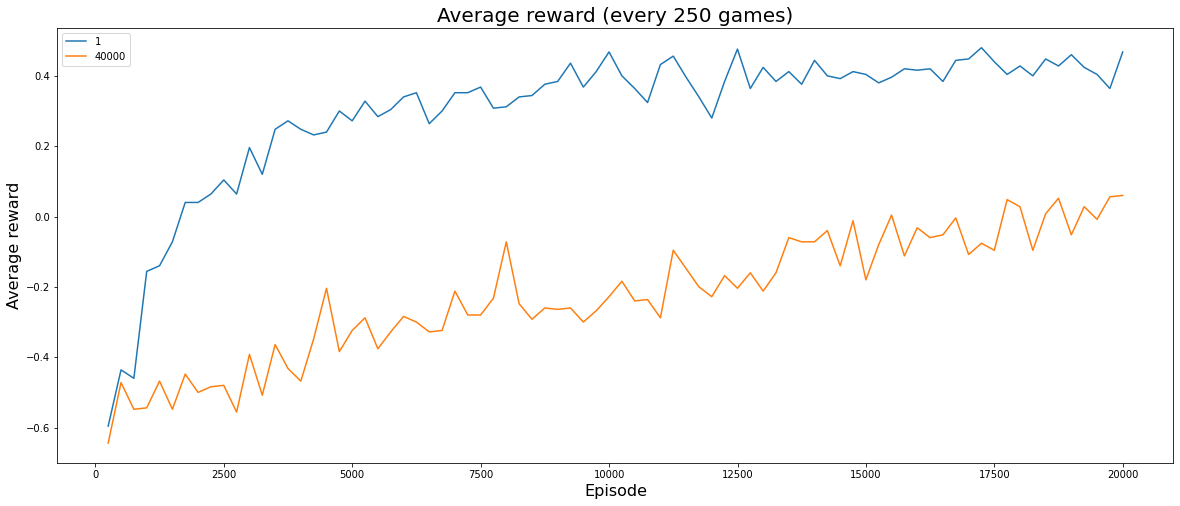

In [12]:
plot_average(x, n_star_rewards, n_star_list)

From the plot we can observe that for small values of $n^*$ the learning is even slower than the case with fixed $\epsilon$. In particular we can see how after $4000$ games the learner still has a average reward aorund $-0.4$ whereas in the previous case with fixed $\epsilon$ it had already a average reward of $-0.2$.

In addition for high values of $n^*$ we have a behaviour similar to the previous case.


## Question 3

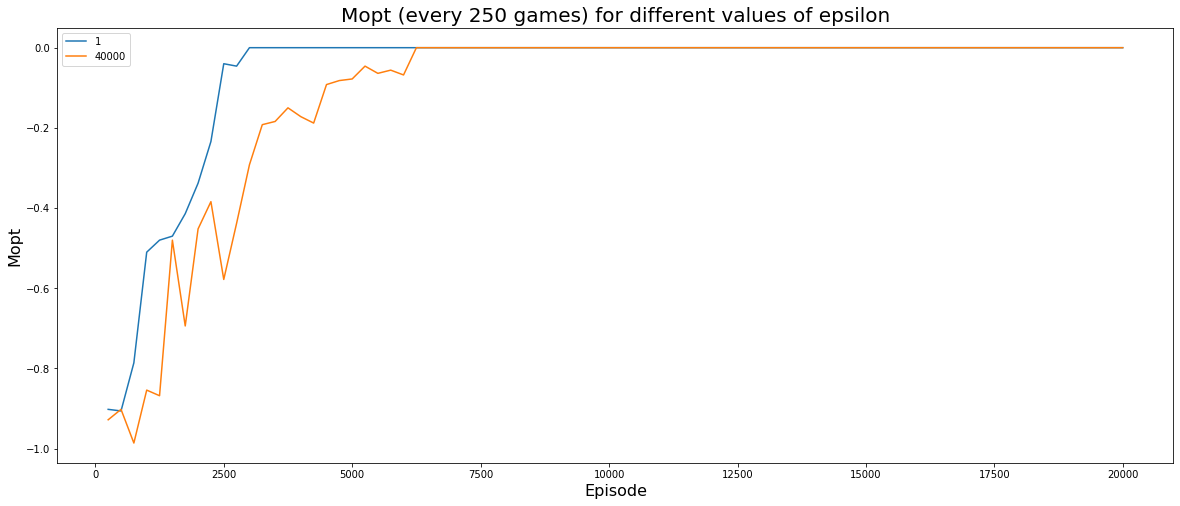

In [13]:
plot_measure(x, n_star_M_opts, n_star_list, m_opt=True)

# plt.show()
#
# fig = go.Figure()
#
# for i, y_i in enumerate(n_star_M_opts):
#     fig.add_trace(go.Scatter(x=x, y=y_i, mode='lines',name=r'$n^* = %d$' % n_star_list[i]))
#
# fig.update_layout(
#     title=r'$M_{opt}\text{ for every %d games for different values of }n^{∗}$' % averaging_steps,
#     xaxis_title=r'$game$',
#     yaxis_title=r'$M_{opt}$',
#     width=1200, height=400
# )
#
# fig.show()

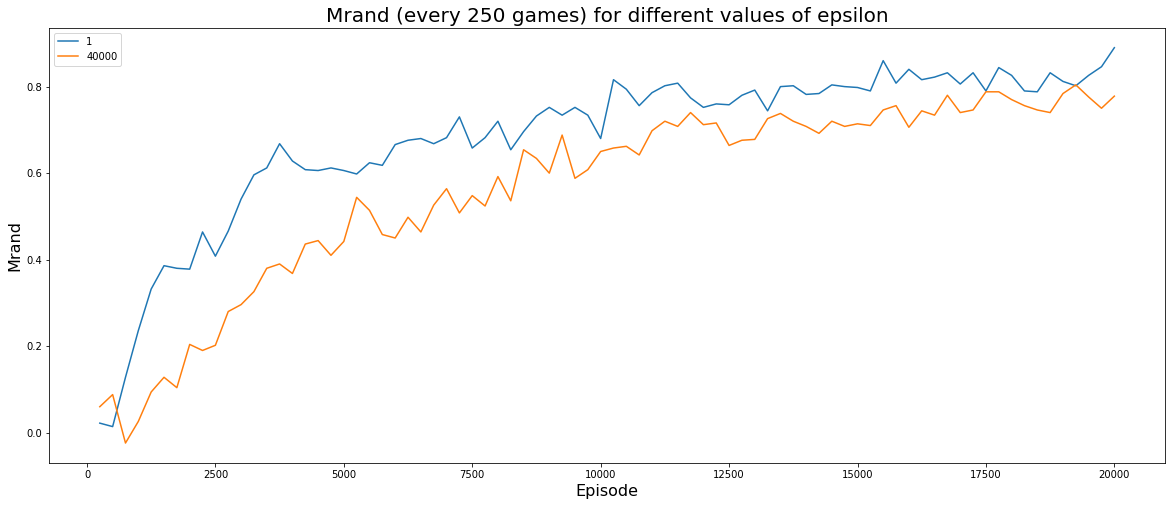

In [15]:
plot_measure(x, n_star_M_rands, n_star_list, m_opt=False)

# fig = go.Figure()
#
# for i, y_i in enumerate(n_star_M_rands):
#     fig.add_trace(go.Scatter(x=x, y=y_i, mode='lines',name=r'$n^* = %d$' % n_star_list[i]))
#
# fig.update_layout(
#     title=r'$M_{rand}\text{ for every %d games for different values of }n^{∗}$' % averaging_steps,
#     xaxis_title=r'$game$',
#     yaxis_title=r'$M_{rand}$',
#     width=1200, height=400
# )
#
# fig.show()

We can observe how in both plots the values of $M_{opt}$ and $M_{rand}$ tend correctly to the respective values $0$ and $1$.
As we saw in the previous case, the learning is worse for small values of $n*$ than with high values. In particular we can see how for small $n^*$, even after $20000$ games the $M_{opt}$ is still around $-0.6$, wherease for high $n^*$ after $20000$ games it has a value around $-0.3$

# 2.1.2

In [9]:
n_star = 40000
n_episodes = 20000
averaging_steps = 250

env = TictactoeEnv()

eps_rewards = []
eps_list = [x for x in np.linspace(0, 1, 11)]
print([round(ep,2) for ep in eps_list])
eps_M_opts = []
eps_M_rands = []
Q_values = []

for eps in eps_list:
    print('Current eps: %.2f' % eps)
    q_player = VariableEpsilonQPlayer(0.05, 0.99, 0.8, 0.1, n_star)
    other_player = OptimalPlayer(epsilon=eps, player=turns[1])
   
    rewards, M_opts, M_rands, x = run_episodes(n_episodes, q_player, other_player, update_epsilon=True)

    if eps==0 or eps==1:
        Q_values.append(q_player.get_Q_values())

    eps_rewards.append(rewards)
    eps_M_opts.append(M_opts)
    eps_M_rands.append(M_rands)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Current eps: 0.00
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current eps: 0.10
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current eps: 0.20
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current eps: 0.30
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current eps: 0.40
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current eps: 0.50
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current eps: 0.60
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current eps: 0.70
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current eps: 0.80
	Current episode: 0
	Current episode: 5000
	Current ep

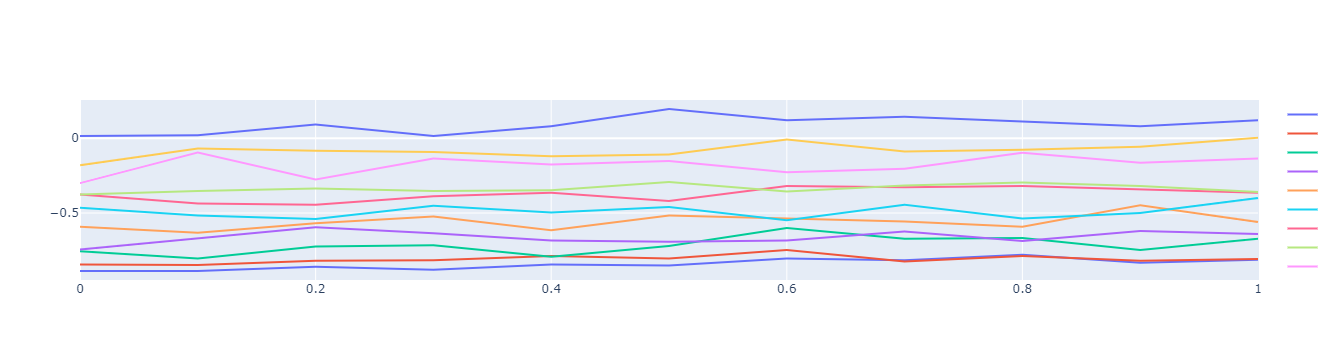

In [10]:
# plt.figure(figsize=(20,8))
# for i,  y_i in enumerate(eps_rewards):
#     sns.lineplot(
#         x=x, y=y_i, label=str(eps_list[i])
#     )
# plt.title('Average reward (every 250 games)', fontsize=20)
# plt.ylabel('Average reward', fontsize=16)
# plt.xlabel('Episode', fontsize=16)

plot_average(x, eps_rewards, eps_list)

# plt.show()
#
# fig = go.Figure()
# for i, eps_reward in enumerate(eps_rewards):
#     fig.add_trace(go.Scatter(x=eps_list, y=eps_reward, mode='lines',name=r'$\epsilon_{opt} = %.2f$' % eps_list[i]))
# fig.show()

## Questions 4,5

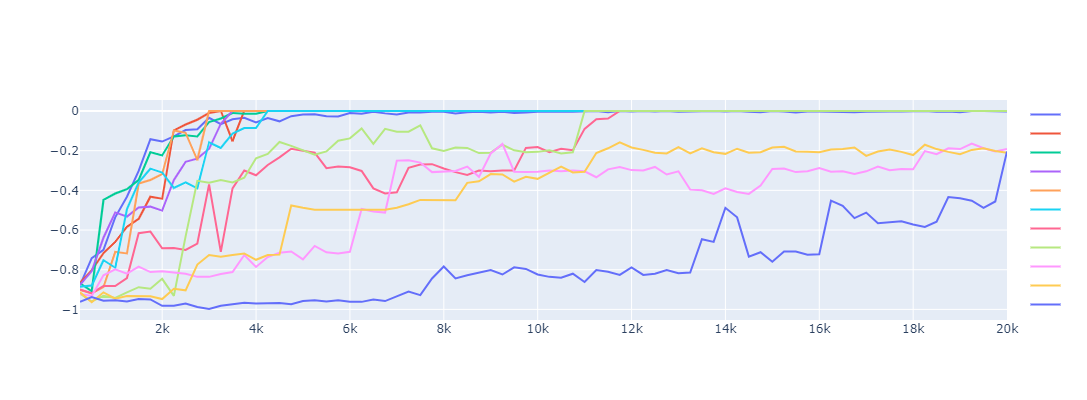

In [11]:
# plt.figure(figsize=(20,8))
# for i, y_i in enumerate(eps_M_opts):
#     sns.lineplot(
#         x=x, y=y_i, label=str(eps_list[i])
#     )
# plt.title('Mopt (every 250 games) for different values of epsilon', fontsize=20)
# plt.ylabel('Mopt', fontsize=16)
# plt.xlabel('Episode', fontsize=16)

plot_measure(x, eps_M_opts, eps_list, m_opt=True)

# fig = go.Figure()
#
# for i, y_i in enumerate(eps_M_opts):
#     fig.add_trace(go.Scatter(x=x, y=y_i, mode='lines',name=r'$\epsilon_{opt} = %.2f$' % eps_list[i]))
#
# fig.update_layout(
#     title=r'$M_{opt}\text{ for every %d games for different values of }\epsilon_{opt}$' % averaging_steps,
#     xaxis_title=r'$game$',
#     yaxis_title=r'$M_{opt}$',
#     width=1200, height=400
# )
#
# fig.show()

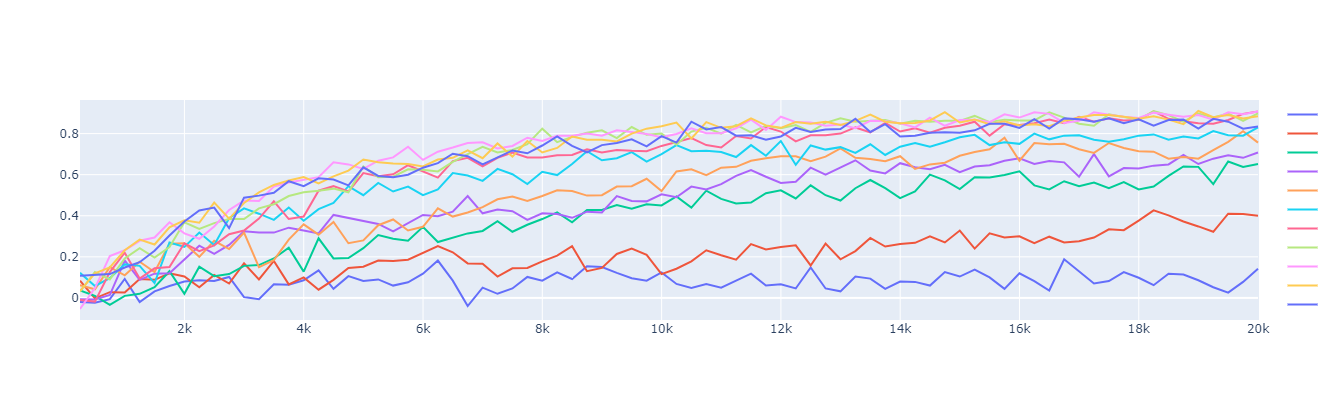

In [12]:
# plt.figure(figsize=(20,8))
# for i, y_i in enumerate(eps_M_rands):
#     sns.lineplot(
#         x=x, y=y_i, label=str(eps_list[i])
#     )
# plt.title('Mrand (every 250 games) for different values of epsilon', fontsize=20)
# plt.ylabel('Mrand', fontsize=16)
# plt.xlabel('Episode', fontsize=16)

plot_measure(x, eps_M_rands, eps_list, m_opt=False)

# fig = go.Figure()
#
# for i, y_i in enumerate(eps_M_rands):
#     fig.add_trace(go.Scatter(x=x, y=y_i, mode='lines',name=r'$\epsilon_{opt} = %.2f$' % eps_list[i]))
#
# fig.update_layout(
#     title=r'$M_{rand}\text{ for every %d games for different values of }\epsilon_{opt}$' % averaging_steps,
#     xaxis_title=r'$game$',
#     yaxis_title=r'$M_{rand}$',
#     width=1200, height=400
# )
#
# fig.show()

We can observe how for $\epsilon_{opt}$ around 0 the player learns way faster than for values of $\epsilon_{opt}$ around 1. This can be explained by considering that is better to learn from a good player that always plays correctly than from a bad player which makes mistakes. 

In [13]:
#to rerun
M_opt_max = np.array(eps_M_opts).max()
M_rand_max = np.array(eps_M_rands).max() 

print("The highest M_opt value is %.2f" % M_opt_max)
print("The highest M_rand value is %.2f" % M_rand_max)

The highest M_opt value is 0.00
The highest M_rand value is 0.91


## Question 6

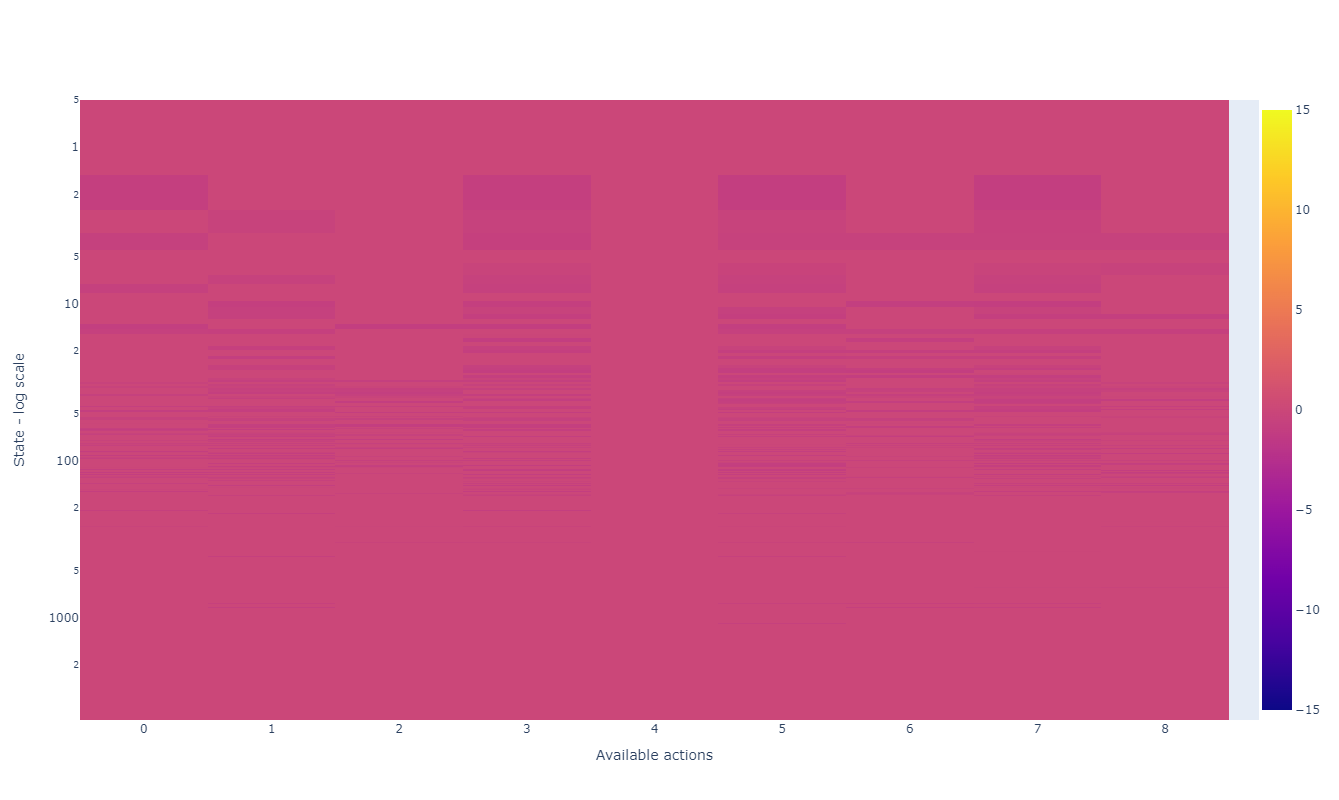

In [14]:
Q_values_1 = list(Q_values[0].values())
fig = px.imshow(Q_values_1,text_auto=True,
                labels=dict(x="Available actions", y="State - log scale", color="$Q_{value}$"),
                                 title="Q1(s,a)")
fig.update_layout(
    width=900, height=800
)

fig.update_yaxes(
    type="log"
)


fig.show()

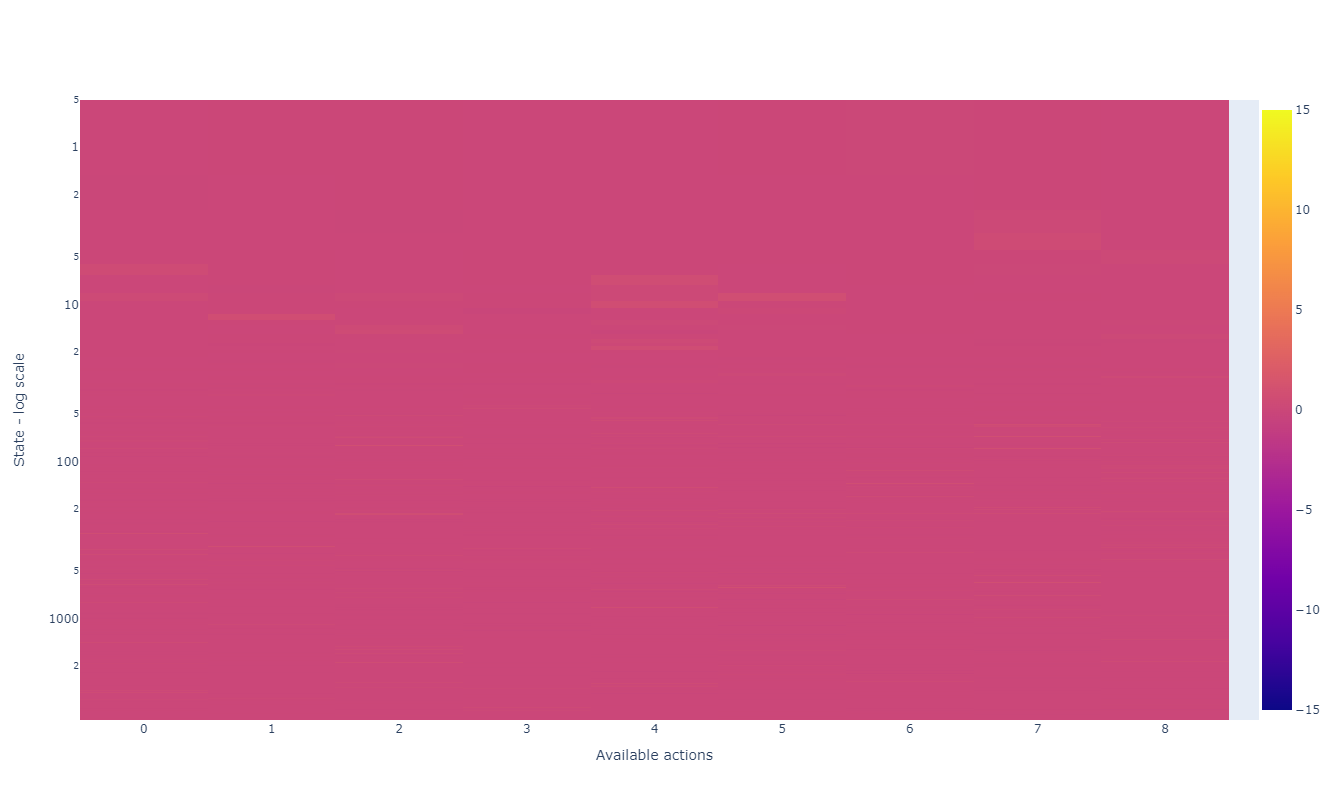

In [15]:
Q_values_2 = list(Q_values[1].values())
fig = px.imshow(Q_values_2,text_auto=True,
                labels=dict(x="Available actions", y="State - log scale", color="$Q_{value}$"),
                                 title="Q2(s,a)")
fig.update_yaxes(
    type="log"
)

fig.update_layout(
    width=900, height=800
)

fig.show()

In order to compare the $Q_{values}$ of Agent 1 and Agent 2 we plot them using a heatmap. In particular, since the number of states is considerably larger than the number of possible action they are plotted on a log-scale.

From the figure we can immediately observe how the $Q_{values}$ of the 2 Agents are different. In particular we can see how the Agent 2, which played with a random player, was not able to learn any specific pattern and rule of the game: indeed the majority of its $Q_{values}$ are around $0$.

On the other hand, Agent 2, which played with the optimal player, learned that some specific actions have to be strictly avoid (we can see some dark cells with Q_{values} around $-15$) whereas other actions are correct (we can see that from the yellow cells with $Q_{values}$ around $11$).

# 2.2

In [1]:
n_episodes = 20000
averaging_steps = 250

env = TictactoeEnv()

eps_rewards = []
eps_list = [round(x,2) for x in np.linspace(0, 1, 11)]
print(eps_list)
eps_M_opts = []
eps_M_rands = []

for eps in eps_list:
    print('Current eps: %.2f' % eps)
    q_player_1 = QPlayer(0.05, 0.99, eps)
    q_player_2 = QPlayer(0.05, 0.99, eps, q_player_1.get_Q_values())
 
    rewards, M_opts, M_rands, x = run_episodes(n_episodes, q_player_1, q_player_2, set_player=False)

    eps_rewards.append(rewards)
    eps_M_opts.append(M_opts)
    eps_M_rands.append(M_rands)

NameError: name 'TictactoeEnv' is not defined

## Question 7

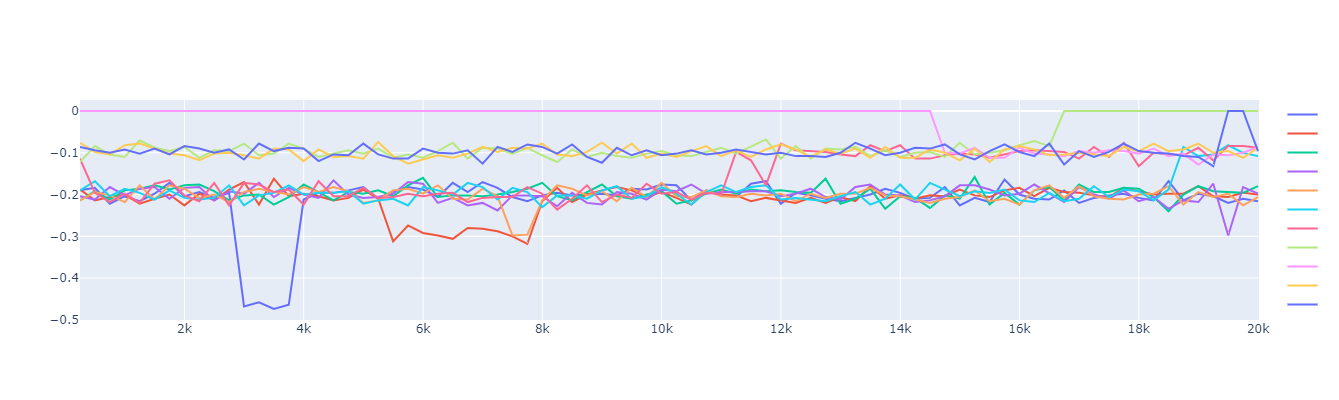

In [17]:
# plt.figure(figsize=(20,8))
# for i, y_i in enumerate(eps_M_opts):
#     sns.lineplot(
#         x=x, y=y_i, label=str(eps_list[i])
#     )
# plt.title('Mopt (every 250 games) for different values of epsilon', fontsize=20)
# plt.ylabel('Mopt', fontsize=16)
# plt.xlabel('Episode', fontsize=16)

plot_measure(x, eps_M_opts, eps_list, m_opt=True)


# fig = go.Figure()
#
# for i, y_i in enumerate(eps_M_opts):
#     fig.add_trace(go.Scatter(x=x, y=y_i, mode='lines',name=r'$\epsilon = %.2f$' % eps_list[i]))
#
# fig.update_layout(
#     title=r'$M_{opt}\text{ for every %d games for different values of }\epsilon$' % averaging_steps,
#     xaxis_title=r'$game$',
#     yaxis_title=r'$M_{opt}$',
#     width=1200, height=400
# )
#
# fig.show()

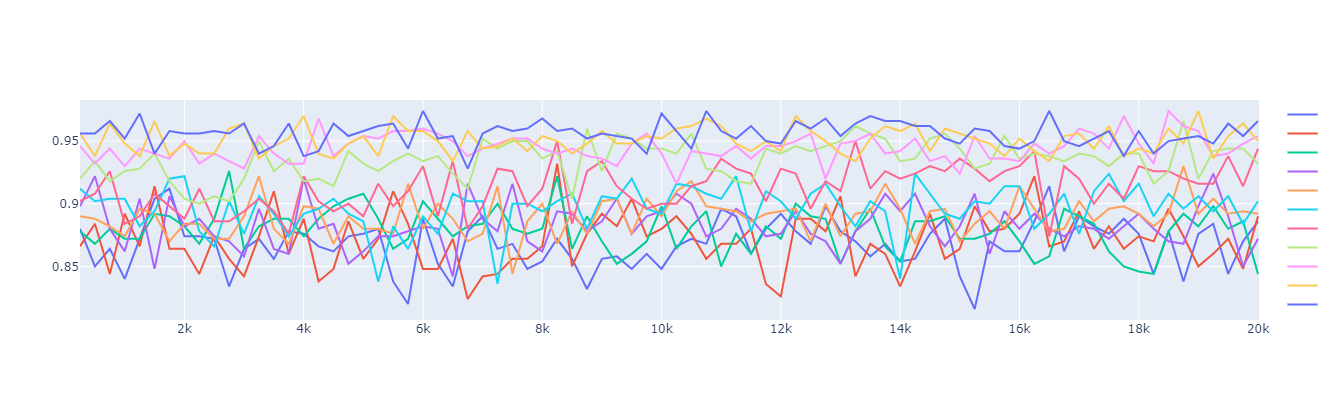

In [18]:
# plt.figure(figsize=(20,8))
# for i, y_i in enumerate(eps_M_rands):
#     sns.lineplot(
#         x=x, y=y_i, label=str(eps_list[i])
#     )
# plt.title('Mrand (every 250 games) for different values of epsilon', fontsize=20)
# plt.ylabel('Mrand', fontsize=16)
# plt.xlabel('Episode', fontsize=16)

plot_measure(x, eps_M_rands, eps_list, m_opt=False)


# fig = go.Figure()
#
# for i, y_i in enumerate(eps_M_rands):
#     fig.add_trace(go.Scatter(x=x, y=y_i, mode='lines',name=r'$\epsilon = %.2f$' % eps_list[i]))
#
# fig.update_layout(
#     title=r'$M_{rand}\text{ for every %d games for different values of }\epsilon$' % averaging_steps,
#     xaxis_title=r'$game$',
#     yaxis_title=r'$M_{rand}$',
#     width=1200, height=400
# )
#
# fig.show()

In this case, we can observe from the plots that the grow in the correct direction as before (i.e $M_{opt}$ grows towards $0$ and $M_{rand}$ towards $1$), however they are slower in the learning process than in the previous case with the optimal player. This can be explained again by considering that it is easier to learn from someone which already plays in the optimal way, which is not the case when the player play by himself, since indeed he is still learning.

Regarding the $\epsilon$ values we can see that for $\epsilon$ near to $0$ the curves grow slowly, which means that the player is not able to learn, whereas for $\epsilon$ near to $1$ they grow faster.

## Questions 8,9


In [19]:
n_episodes = 20000
averaging_steps = 250

env = TictactoeEnv()

n_star_rewards = []
n_star_list = [int(x) for x in np.linspace(1, 200, 11)]
print(n_star_list)
n_star_M_opts = []
n_star_M_rands = []


for n_star in n_star_list:
    print('Current n_star: %d' % n_star)
    q_player = VariableEpsilonQPlayer(0.05, 0.99, 0.8, 0.1, n_star)
    q_player_2 = VariableEpsilonQPlayer(0.05, 0.99, 0.8, 0.1, n_star, q_player.get_Q_values())

    rewards, M_opts, M_rands, x = run_episodes(n_episodes, q_player, q_player_2, update_epsilon=True, update_other_epsilon=True, set_player=False)

    n_star_rewards.append(rewards)
    n_star_M_opts.append(M_opts)
    n_star_M_rands.append(M_rands)

Q_value = q_player.get_Q_values()

[1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
Current n_star: 1
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current n_star: 20
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current n_star: 40
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current n_star: 60
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current n_star: 80
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current n_star: 100
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current n_star: 120
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current n_star: 140
	Current episode: 0
	Current episode: 5000
	Current episode: 10000
	Current episode: 15000
Current n_star: 160
	Current episode: 0
	Current episode: 5000
	Curr

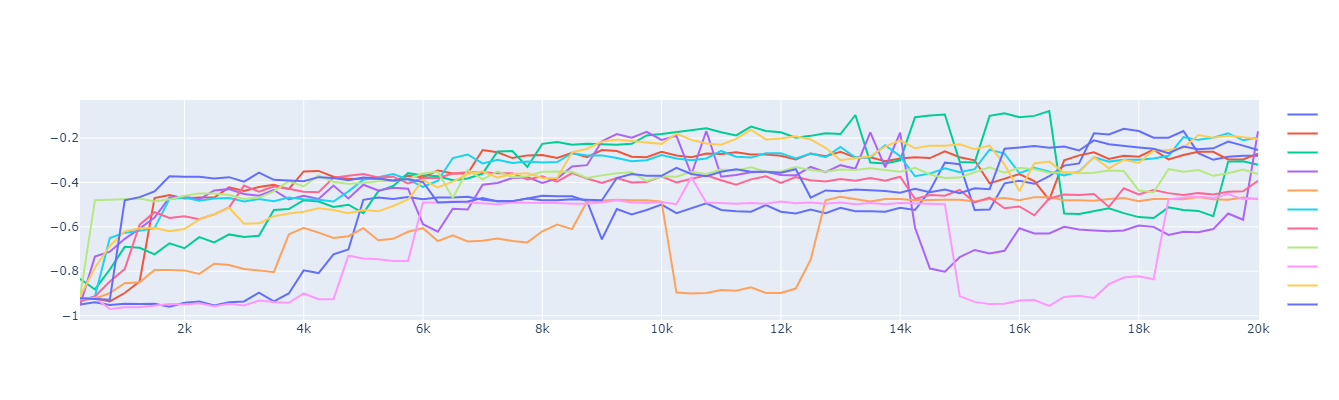

In [20]:
plot_measure(x, n_star_M_opts, n_star_list, m_opt=True)


# fig = go.Figure()
#
# for i, y_i in enumerate(n_star_M_opts):
#     fig.add_trace(go.Scatter(x=x, y=y_i, mode='lines',name=r'$n^* = %d$' % n_star_list[i]))
#
# fig.update_layout(
#     title=r'$M_{opt}\text{ for every %d games for different values of }n^{∗}$' % averaging_steps,
#     xaxis_title=r'$game$',
#     yaxis_title=r'$M_{opt}$',
#     width=1200, height=400
# )
#
# fig.show()

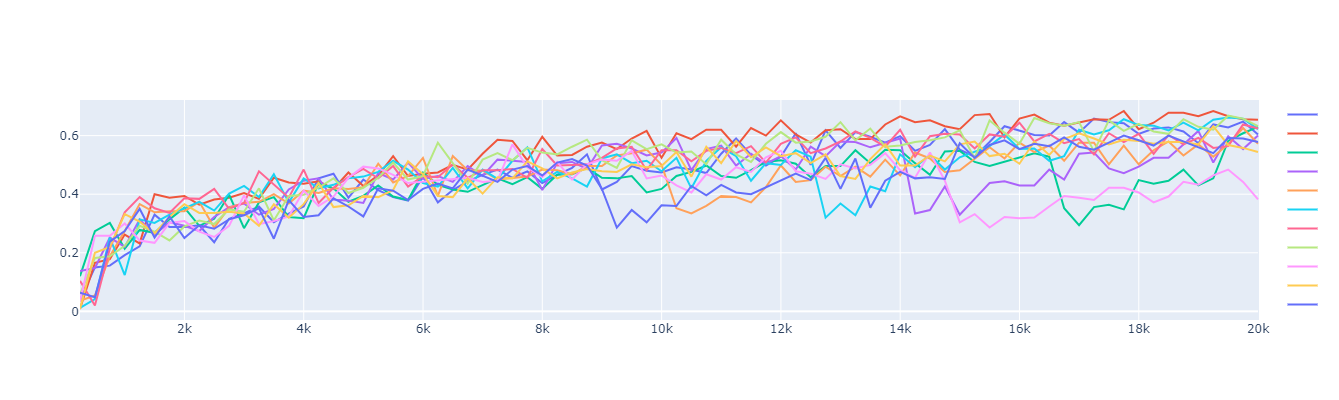

In [21]:
plot_measure(x, n_star_M_rands, n_star_list, m_opt=False)

# fig = go.Figure()
#
# for i, y_i in enumerate(n_star_M_rands):
#     fig.add_trace(go.Scatter(x=x, y=y_i, mode='lines',name=r'$n^* = %d$' % n_star_list[i]))
#
# fig.update_layout(
#     title=r'$M_{rand}\text{ for every %d games for different values of }n^{∗}$' % averaging_steps,
#     xaxis_title=r'$game$',
#     yaxis_title=r'$M_{rand}$',
#     width=1200, height=400
# )
#
# fig.show()

??

In [22]:
M_opt_max = np.array(n_star_M_opts).max()
M_rand_max = np.array(n_star_M_rands).max() 

print("The highest M_opt value is %.2f" % M_opt_max)
print("The highest M_rand value is %.2f" % M_rand_max)

The highest M_opt value is -0.08
The highest M_rand value is 0.68


## Question 10

In [23]:
#get keys of states
key_state_1=list(Q_value.keys())[0]
key_state_2=list(Q_value.keys())[-1]
key_state_3=list(Q_value.keys())[int(len(Q_value.keys())/2)]

In [24]:
#get available actions
available_actions_state_1=Q_value.get(key_state_1)
available_actions_state_2=Q_value.get(key_state_2)
available_actions_state_3=Q_value.get(key_state_3)

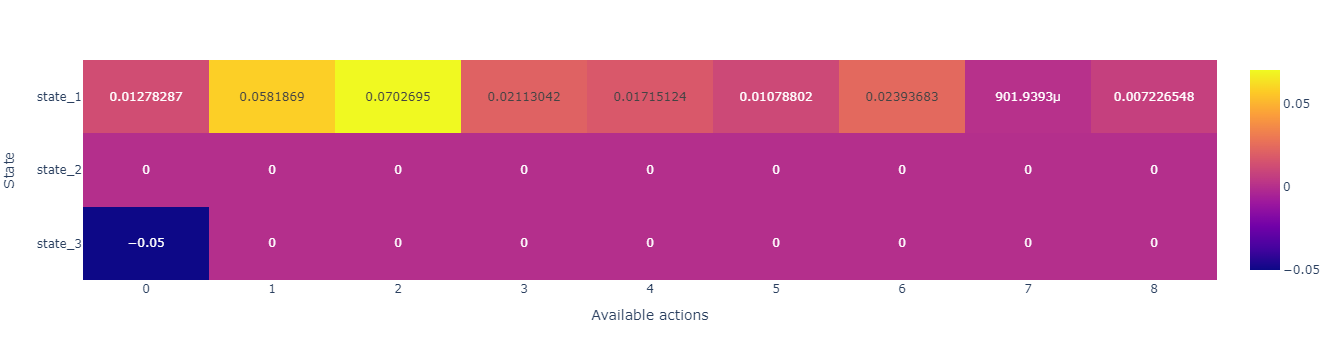

In [25]:
import plotly.express as px

fig = px.imshow([available_actions_state_1, available_actions_state_2, available_actions_state_3],text_auto=True,
                labels=dict(x="Available actions", y="State", color="$Q_{value}$"),
                                y=['state_1', 'state_2', 'state_3'])
fig.show()

# 3.2

## Question 10

In [19]:
torch.cat([x,torch.tensor([3.,2.])]).mean()

tensor(2.)

In [10]:
x=torch.tensor([2,1])

In [21]:
n_episodes = 20000
averaging_steps = 250
update_steps = 500
turns = np.array(['X','O'])

q_player = DeepQPlayer(0.2)
env = TictactoeEnv()

rewards = []
losses = []
average_reward = 0.
average_loss = []

other_player = OptimalPlayer(epsilon=0.5, player=turns[1])
x = []

for episode in tqdm(range(n_episodes)):
        # Update players
        other_player.set_player(turns[1])
        
        # Play game
        loss, reward = play_deep_game(env, q_player, other_player, turns, testing=False)
        average_reward += reward
        average_loss.append(loss)

        if episode % (update_steps-1) == 0:
            q_player.update_target()

        if episode % averaging_steps == averaging_steps - 1:
            average_reward /= averaging_steps
            rewards.append(average_reward)
            losses.append(torch.cat(average_loss).mean())
            average_reward = 0.
            average_loss = 0.
            x.append(episode)

        # Change first player
        turns = turns[::-1]

  0%|          | 0/20000 [00:00<?, ?it/s]


NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

CPU: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterCPU.cpp:21063 [kernel]
CUDA: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterCUDA.cpp:29726 [kernel]
QuantizedCPU: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterQuantizedCPU.cpp:1258 [kernel]
BackendSelect: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradCPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradCUDA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradXLA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradLazy: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradXPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradMLC: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradHPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradNestedTensor: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse1: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse2: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse3: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_3.cpp:11380 [autograd kernel]
Tracer: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\TraceType_3.cpp:11220 [kernel]
AutocastCPU: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:305 [backend fallback]
Batched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\FunctionalizeFallbackKernel.cpp:52 [backend fallback]
